In [78]:
!!pip install lightgbm

['Collecting lightgbm',
 '  Downloading lightgbm-4.5.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)',
 'Requirement already satisfied: numpy>=1.17.0 in /Users/animesh/anaconda3/lib/python3.11/site-packages (from lightgbm) (1.24.3)',
 'Requirement already satisfied: scipy in /Users/animesh/anaconda3/lib/python3.11/site-packages (from lightgbm) (1.10.1)',
 'Downloading lightgbm-4.5.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)',
 '\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.6 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.6 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.3/1.6 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.3/1.6 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.5/1.6

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm

In [42]:
df = pd.read_csv("demographic_dataset.csv")

In [43]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [44]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [45]:
df = df.drop(columns=['person_emp_length', 'loan_intent', 'loan_grade', 'cb_person_cred_hist_length'])

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 32581 non-null  int64  
 1   person_income              32581 non-null  int64  
 2   person_home_ownership      32581 non-null  object 
 3   loan_amnt                  32581 non-null  int64  
 4   loan_int_rate              29465 non-null  float64
 5   loan_status                32581 non-null  int64  
 6   loan_percent_income        32581 non-null  float64
 7   cb_person_default_on_file  32581 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 2.0+ MB


In [47]:
print("\nDescriptive statistics of the training set")
df.describe().T


Descriptive statistics of the training set


,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83


In [48]:
train_df = df

In [49]:
categorical_features = train_df.select_dtypes(include=['object']).columns
numerical_features = train_df.select_dtypes(include=[np.number]).columns

print("\nCategorical Variables:", categorical_features)
print("Numeric Variables:", numerical_features)


Categorical Variables: Index(['person_home_ownership', 'cb_person_default_on_file'], dtype='object')
Numeric Variables: Index(['person_age', 'person_income', 'loan_amnt', 'loan_int_rate',
       'loan_status', 'loan_percent_income'],
      dtype='object')


In [50]:
# Analysis of categorical variables
for col in categorical_features:
    print(f"\nDistribution of categorical variable {col}:")
    print(train_df[col].value_counts())


Distribution of categorical variable person_home_ownership:
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64

Distribution of categorical variable cb_person_default_on_file:
N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64


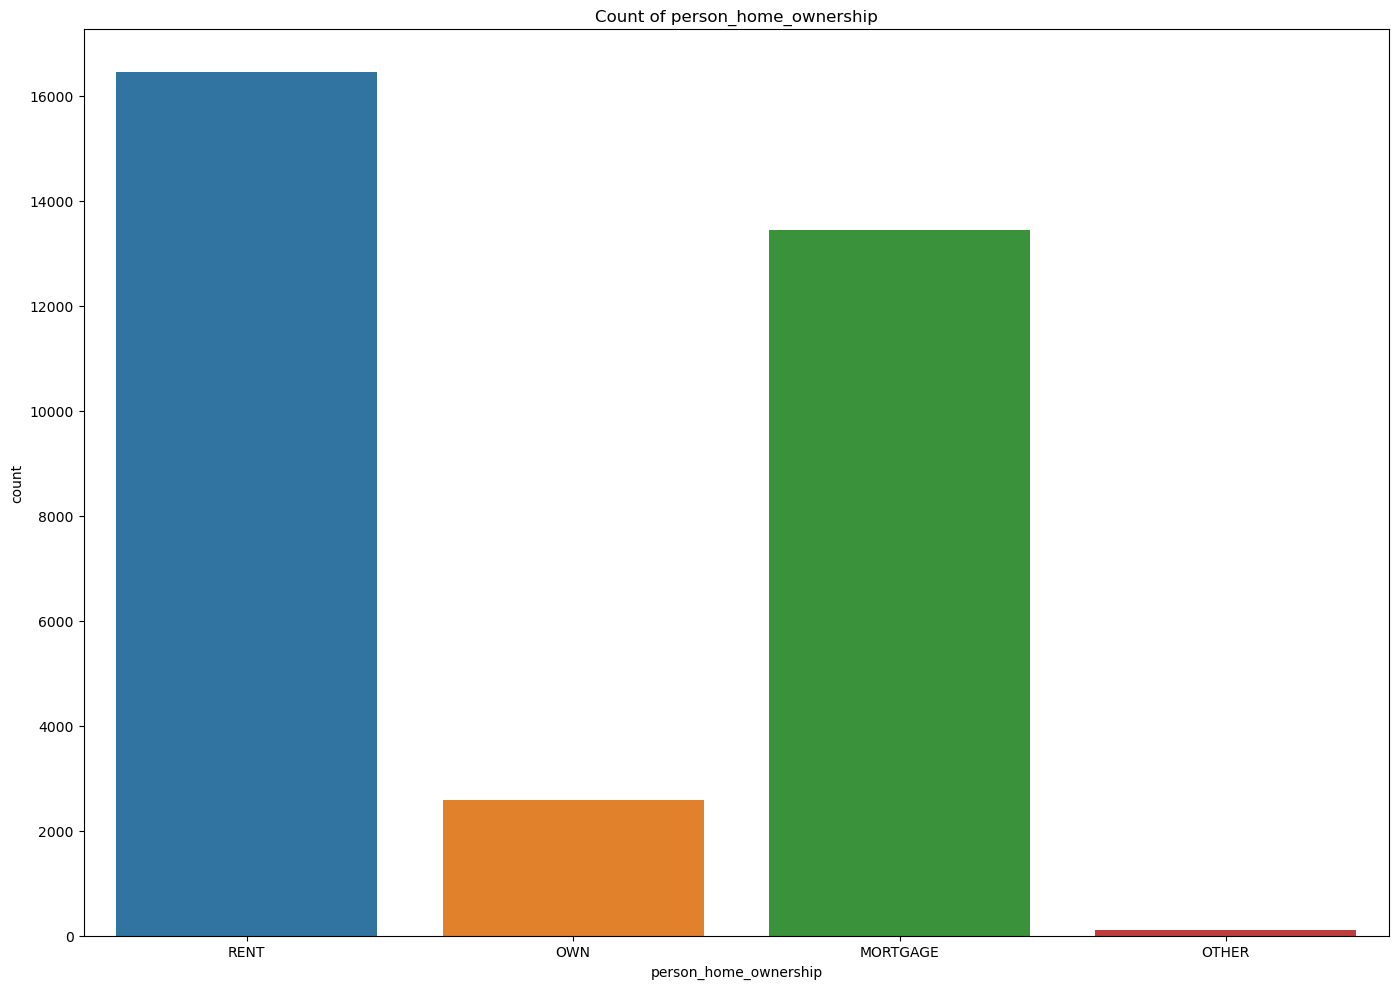

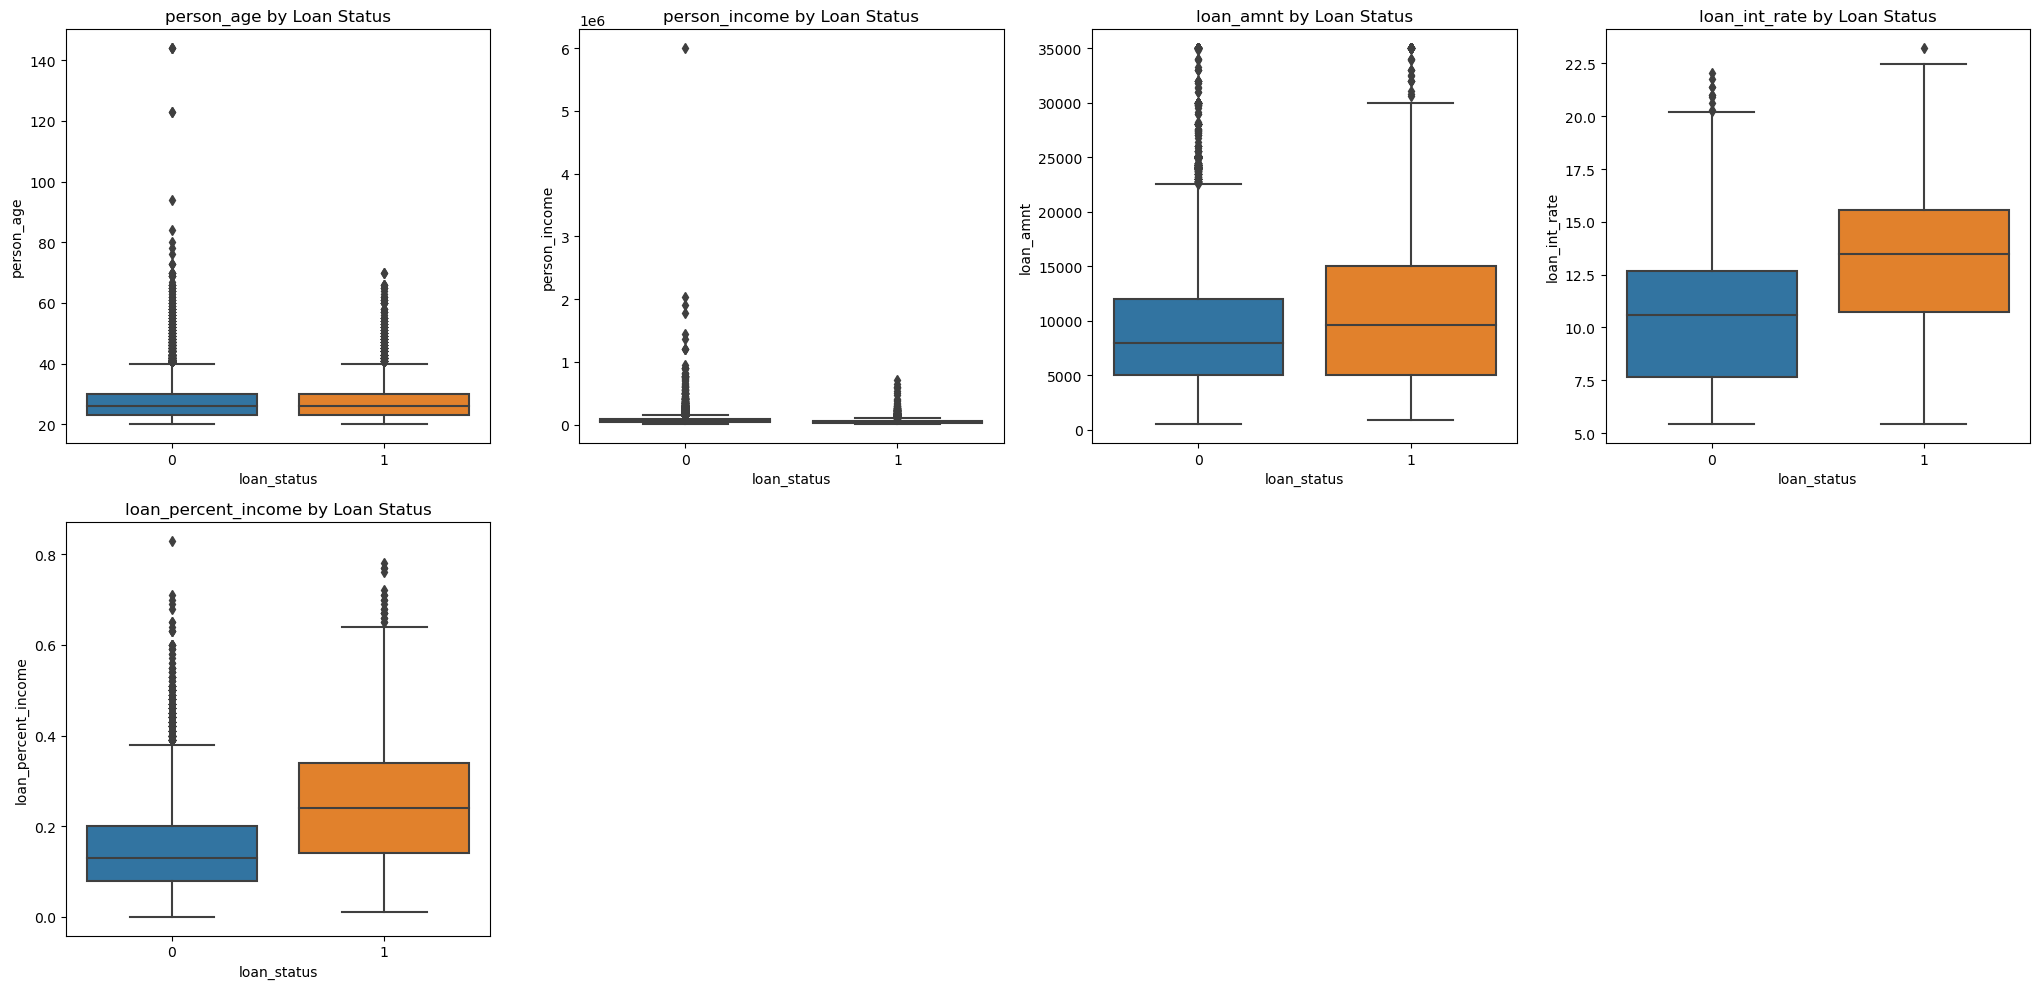

In [52]:
plt.figure(figsize=(40.5, 10))
categorical_cols = ['person_home_ownership']
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=train_df[col])
    plt.title(f'Count of {col}')
    plt.grid(False)
    plt.tight_layout()
plt.show()

# 4. Comparison of distributions
numerical_cols = ['person_age', 'person_income', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income',
                  ]

# Boxplots chart
print()
print()
plt.figure(figsize=(20.5, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='loan_status', y=col, data=train_df)
    plt.title(f'{col} by Loan Status')
    plt.grid(False)
plt.tight_layout()
plt.show()

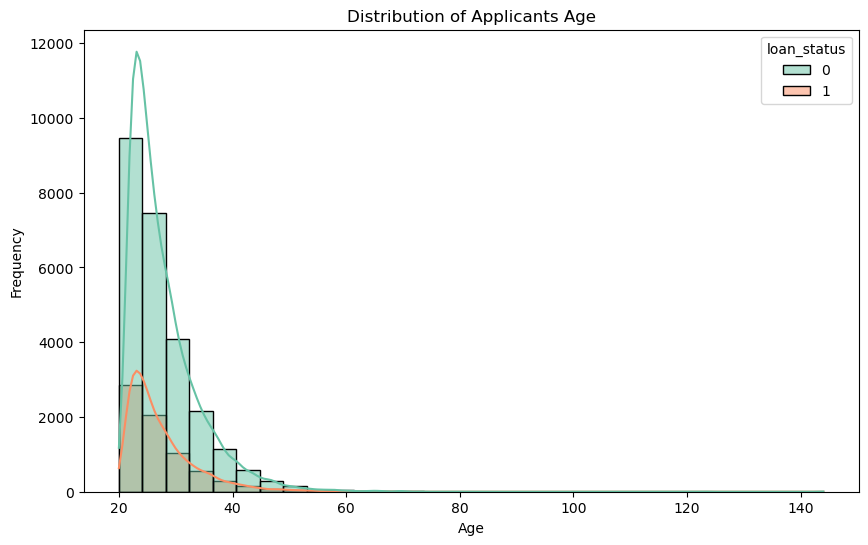

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='person_age', hue='loan_status', bins=30, kde=True, palette='Set2')
plt.title('Distribution of Applicants Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

/var/folders/69/qdzv4_6n7vvcbx7bnb5syht00000gn/T/ipykernel_51388/2777566923.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=train_df, x='person_income', y='loan_amnt', alpha=0.6, palette='Set2')


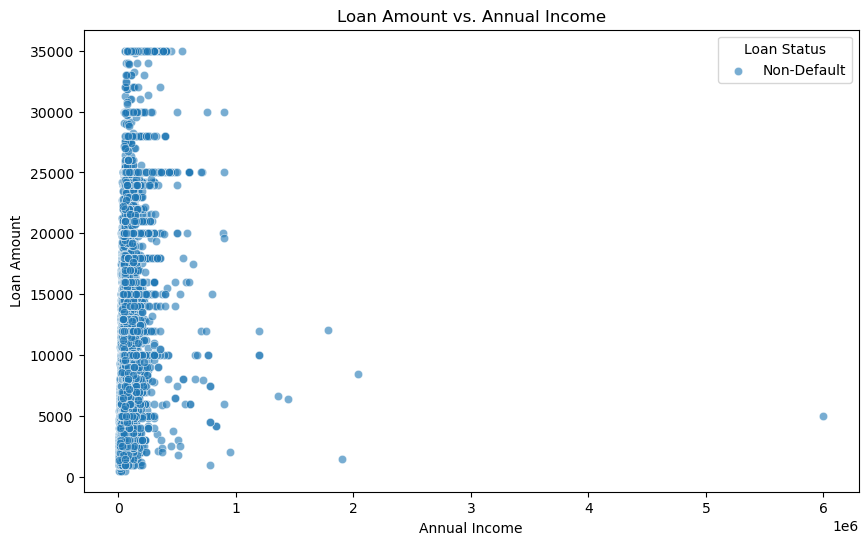

In [54]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='person_income', y='loan_amnt', alpha=0.6, palette='Set2')
plt.title('Loan Amount vs. Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.legend(title='Loan Status', loc='upper right', labels=['Non-Default', 'Default'])
plt.grid(False)
plt.show()

In [55]:
# 1. Handling Missing Values
print("Number of missing values ​​per column:")
print(train_df.isnull().sum())

Number of missing values ​​per column:
person_age                      0
person_income                   0
person_home_ownership           0
loan_amnt                       0
loan_int_rate                3116
loan_status                     0
loan_percent_income             0
cb_person_default_on_file       0
dtype: int64


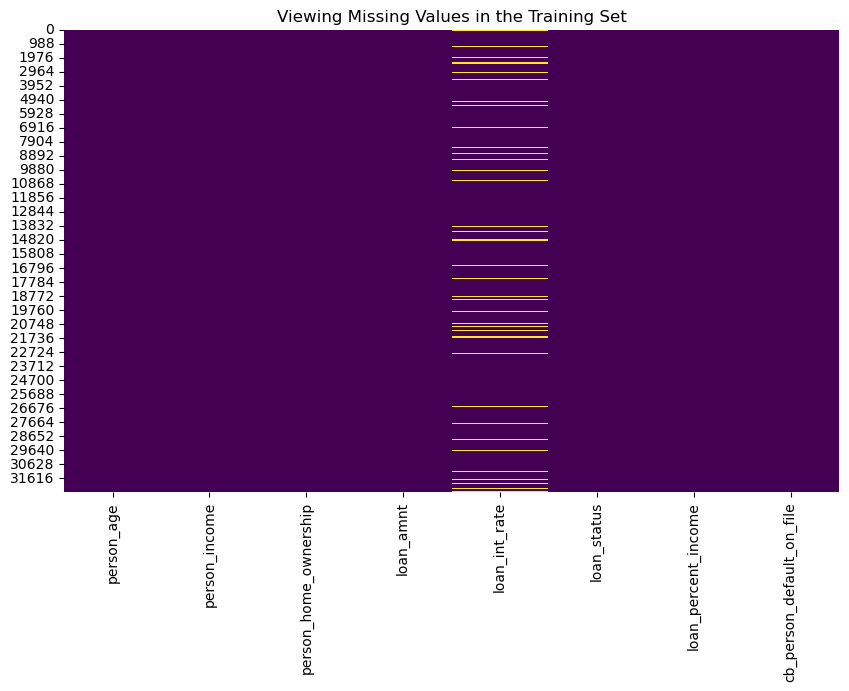

In [56]:
# View missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Viewing Missing Values in the Training Set")
plt.show()

In [57]:
train_df = train_df.dropna(subset=['loan_int_rate'])
print(train_df.isnull().sum())

person_age                   0
person_income                0
person_home_ownership        0
loan_amnt                    0
loan_int_rate                0
loan_status                  0
loan_percent_income          0
cb_person_default_on_file    0
dtype: int64


In [69]:
# Feature Engineering
# Importing library
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoder = LabelEncoder()

# Aplicando nas colunas transformando em númericas
train_df['person_home_ownership'] = label_encoder.fit_transform(train_df['person_home_ownership'])
train_df['cb_person_default_on_file'] = label_encoder.fit_transform(train_df['cb_person_default_on_file'])

/var/folders/69/qdzv4_6n7vvcbx7bnb5syht00000gn/T/ipykernel_51388/3977361702.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['person_home_ownership'] = label_encoder.fit_transform(train_df['person_home_ownership'])
/var/folders/69/qdzv4_6n7vvcbx7bnb5syht00000gn/T/ipykernel_51388/3977361702.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cb_person_default_on_file'] = label_encoder.fit_transform(train_df['cb_person_default_on_file'])


In [70]:
label_encoder

LabelEncoder()

In [71]:
train_df.head()

,person_age,person_income,person_home_ownership,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file
0,22,59000,3,35000,16.02,1,0.59,1
1,21,9600,2,1000,11.14,0,0.10,0
2,25,9600,0,5500,12.87,1,0.57,0
3,23,65500,3,35000,15.23,1,0.53,0
4,24,54400,3,35000,14.27,1,0.55,1


In [72]:
# Resources
X = train_df.drop(columns=['loan_status'])

# Target variable
y = train_df['loan_status']

In [73]:
X.shape

(29465, 7)

In [74]:
y.shape

(29465,)

In [75]:
# Importing library
from sklearn.model_selection import train_test_split

# Training and testing division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting categorical columns to dummy variables
#X_train = pd.get_dummies(X_train)
#X_test = pd.get_dummies(X_test)

# Viewing training data
print("Viewing rows and columns given by X train", X_train.shape)

# Viewing test data
print("Viewing rows and columns given y train", y_train.shape)

Viewing rows and columns given by X train (23572, 7)
Viewing rows and columns given y train (23572,)


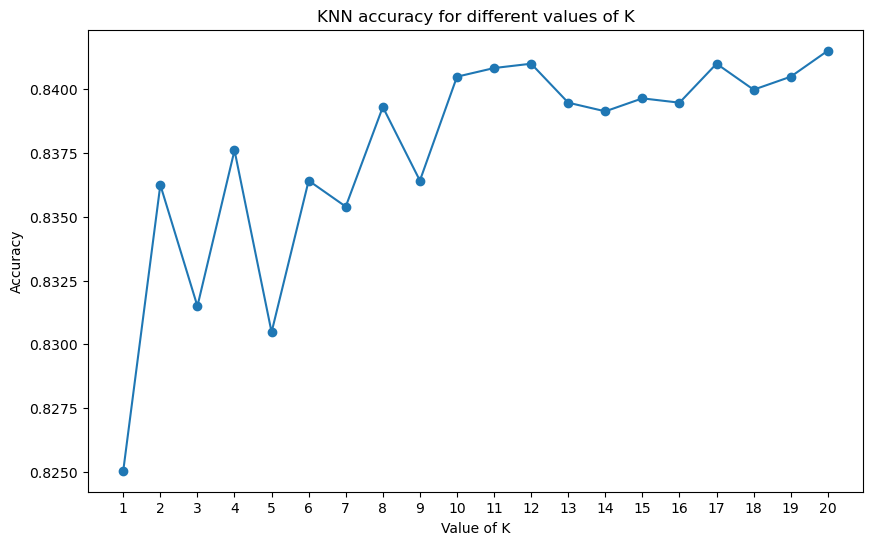

Best value of K: 20
Corresponding accuracy: 0.8415068725606651


In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Find the ideal value of K
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title('KNN accuracy for different values ​​of K')
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(False)
plt.show()

# Find the value of K with the greatest accuracy
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)
print(f"Best value of K: {best_k}")
print(f"Corresponding accuracy: {best_accuracy}")

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Models to be evaluated
models = [
    
    # Naive Bayes Model
    GaussianNB(),
    
    # Decision Tree Model
    DecisionTreeClassifier(random_state=42),
    
    # Random forest model
    RandomForestClassifier(n_estimators=100, random_state=42),
    
    # Logistic regression model
    LogisticRegression(random_state=50),
    
    # Ada Boost Model
    AdaBoostClassifier(random_state=45),
    
    # XGBoost Model
    # Parameter tree_method='gpu_hist' for XGBoost GPU
    XGBClassifier(random_state=42),
    
    # LightGBM Model
    # Parameter device='gpu' for LightGBM GPU
    LGBMClassifier(num_leaves=31,
                   boosting_type='gbdt',
                   bagging_fraction= 0.9,
                   learning_rate=0.05,
                   feature_fraction=0.9,
                   bagging_freq=50,
                   verbose=50),
    
    # K-Nearest Neighbors Model
    KNeighborsClassifier(n_neighbors=best_k),
]

# Evaluate each model
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    print(model)
    print()
    print(f"Model {i+1}: {type(model).__name__}")
    print()
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")
    print("-----------------")

GaussianNB()

Model 1: GaussianNB

Training Accuracy: 0.8130408959782793
Testing Accuracy: 0.8145257084676735
-----------------
DecisionTreeClassifier(random_state=42)

Model 2: DecisionTreeClassifier

Training Accuracy: 0.9997030375021212
Testing Accuracy: 0.8528762939080264
-----------------
RandomForestClassifier(random_state=42)

Model 3: RandomForestClassifier

Training Accuracy: 0.9997030375021212
Testing Accuracy: 0.8978449007296793
-----------------
LogisticRegression(random_state=50)

Model 4: LogisticRegression

Training Accuracy: 0.8042168674698795
Testing Accuracy: 0.8046835228236892
-----------------
AdaBoostClassifier(random_state=45)

Model 5: AdaBoostClassifier

Training Accuracy: 0.8719667402002376
Testing Accuracy: 0.8695061937892414
-----------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable

KNeighborsClassifier(n_neighbors=20)

Model 8: KNeighborsClassifier

Training Accuracy: 0.8482521635839131
Testing Accuracy: 0.8415068725606651
-----------------


Based on the testing accuracy, XGBClassifier and LGBMClassifier are the most suitable models for this dataset, as they both achieve the highest testing accuracies of 0.9359 while maintaining strong training performance. If computational efficiency is a consideration, the LGBMClassifier using GPU can be advantageous

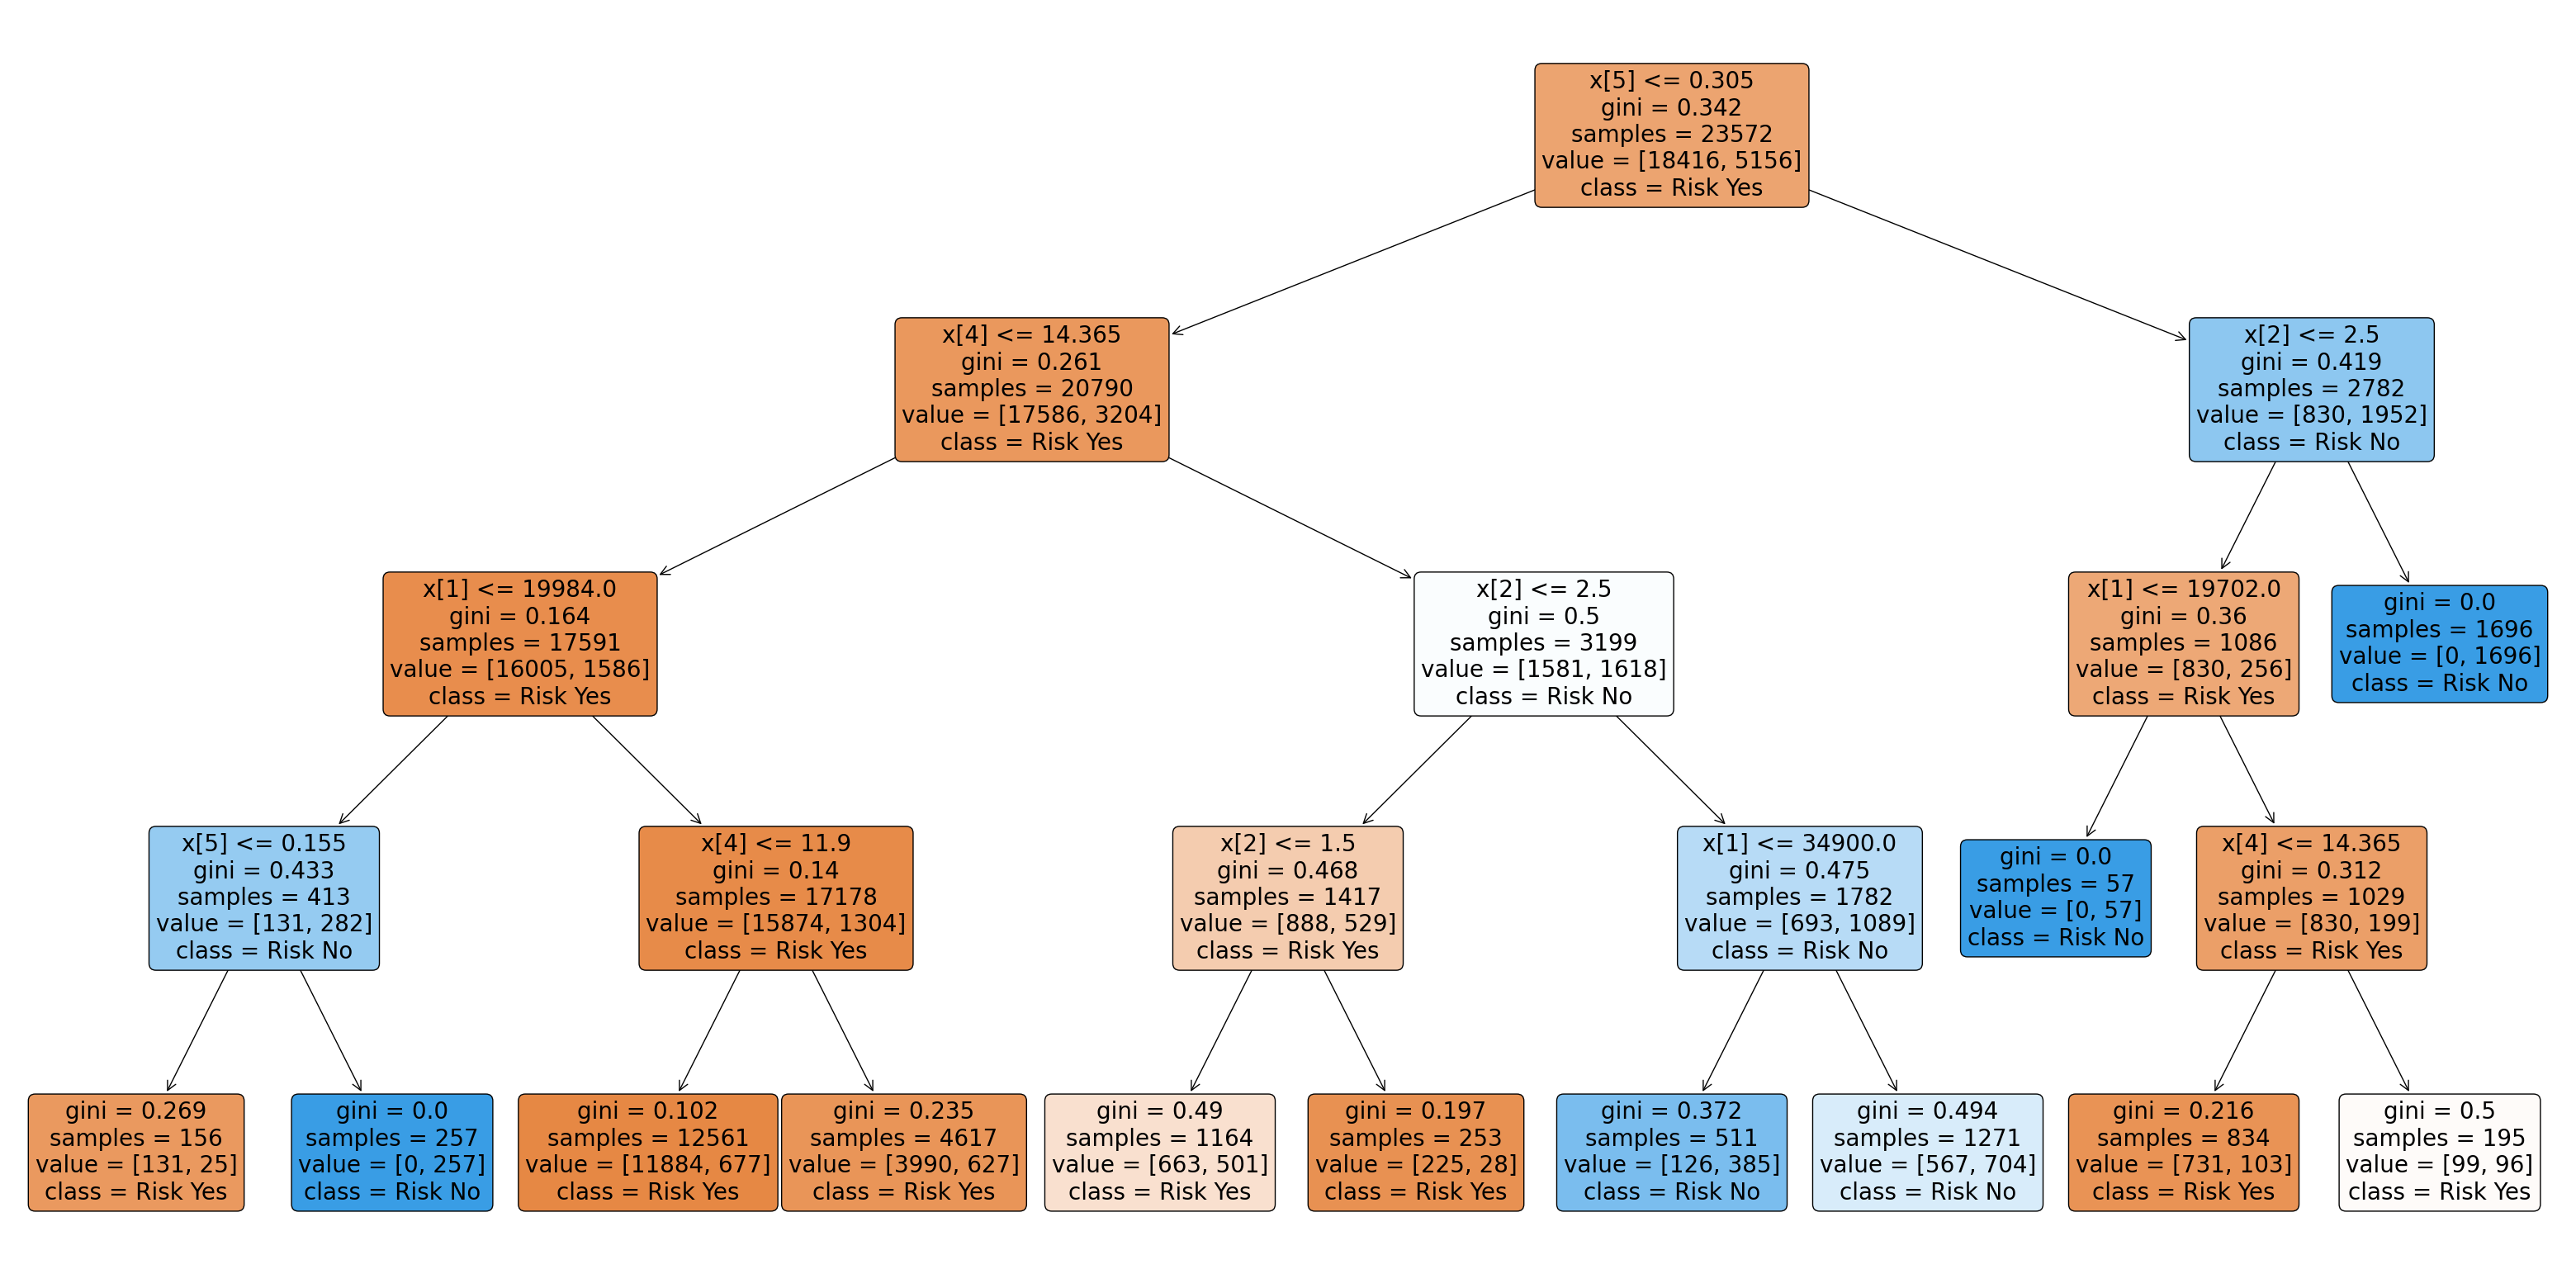

In [82]:
from sklearn.tree import DecisionTreeClassifier

# Creating decision tree model
model_dtc = DecisionTreeClassifier(max_depth = 4, random_state = 0)

# Model training
model_dtc_fit = model_dtc.fit(X_train, y_train)

#plot tree
# importing library to plot trees
from sklearn import tree
fig, ax = plt.subplots(figsize=(40, 20), facecolor = "w")
tree.plot_tree(model_dtc,
               ax = ax,
               fontsize = 20,
               rounded = True,
               filled = True,
               class_names = ["Risk Yes", "Risk No"])
plt.show()

In [83]:
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.8482521635839131
Testing Accuracy: 0.8415068725606651


In [84]:
predictions = model.predict(X_test)

In [102]:
# Find the indices where the predictions are 1
indices_with_1 = np.where(predictions == 1)[0]

# Extract the rows from X_test where the predictions are 1
X_test_with_1 = X_test.iloc[indices_with_1]

# Display the corresponding X_test rows
print(X_test_with_1)

       person_age  person_income  person_home_ownership  loan_amnt  \
18158          30          15600                      0       6250   
20443          33          14076                      3       4800   
15567          21          19800                      2       6800   
26730          31          35000                      3      15000   
29391          37          25000                      2      10625   
...           ...            ...                    ...        ...   
9865           25          59000                      0       5000   
29394          43          25000                      0      10000   
8168           22          56000                      0      20000   
10672          25          32000                      3      10000   
944            24          35004                      3      18250   

       loan_int_rate  loan_percent_income  cb_person_default_on_file  
18158           5.79                 0.40                          0  
20443           6

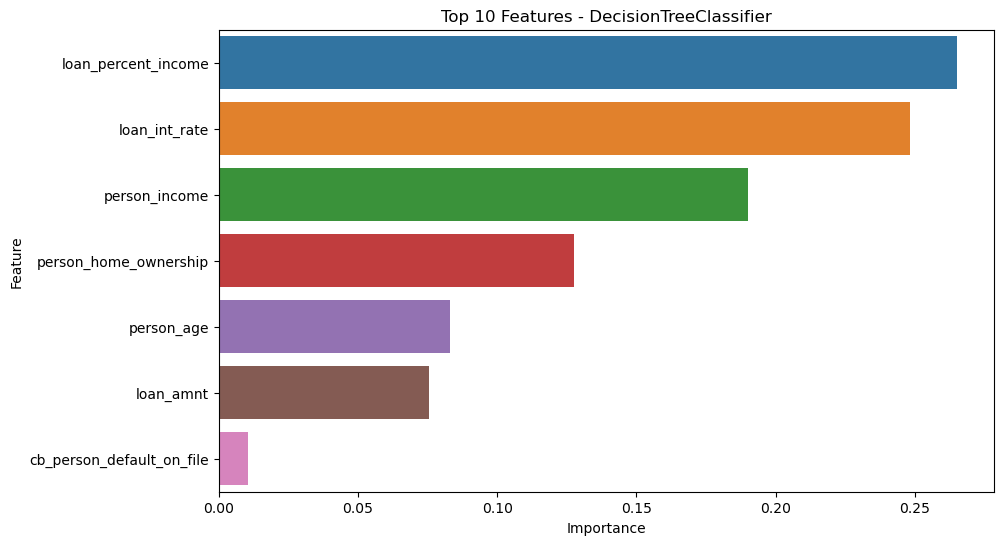

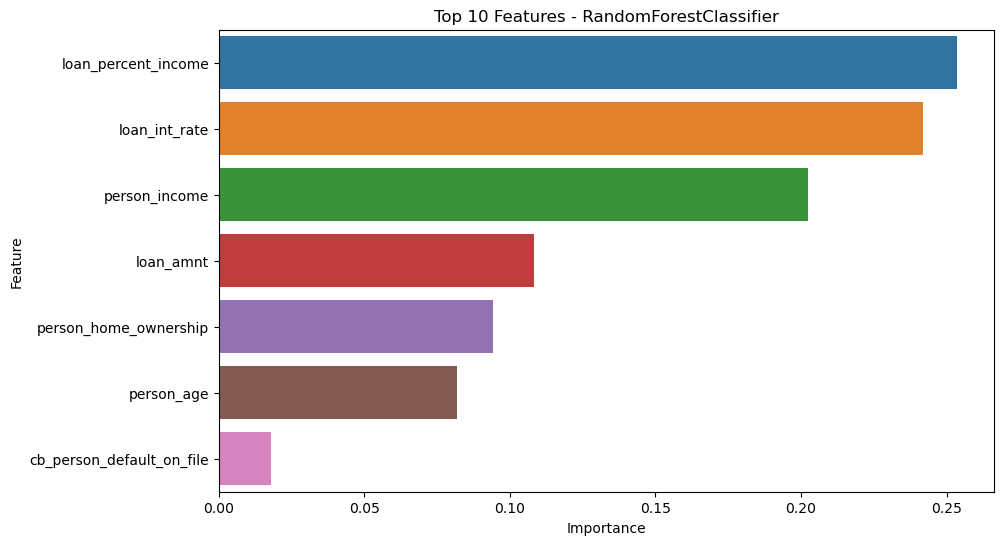

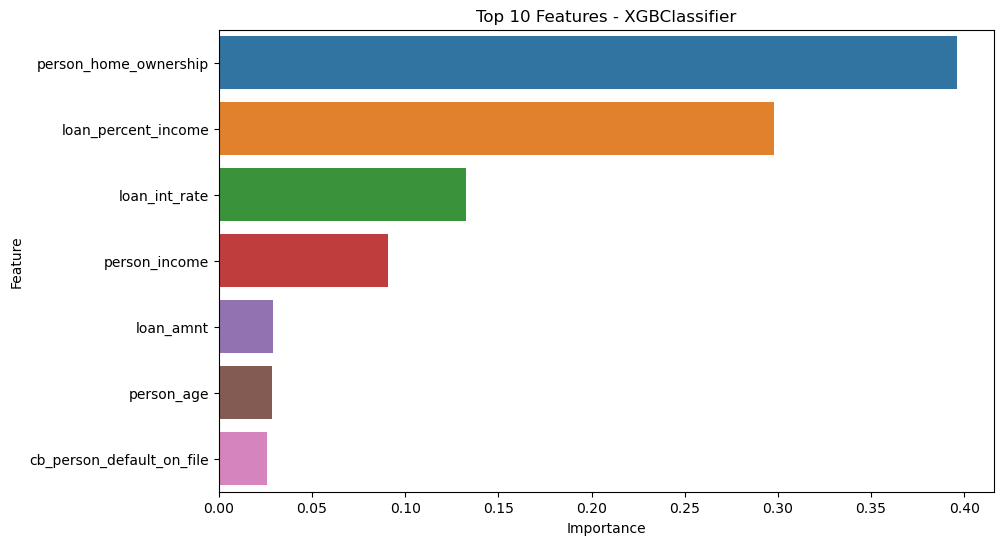

[LightGBM] [Info] Number of positive: 5156, number of negative: 18416
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.176432
[LightGBM] [Debug] init for col-wise cost 0.000001 seconds, init for row-wise cost 0.000275 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 23572, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218734 -> initscore=-1.273059
[LightGBM] [Info] Start training from score -1.273059
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained 

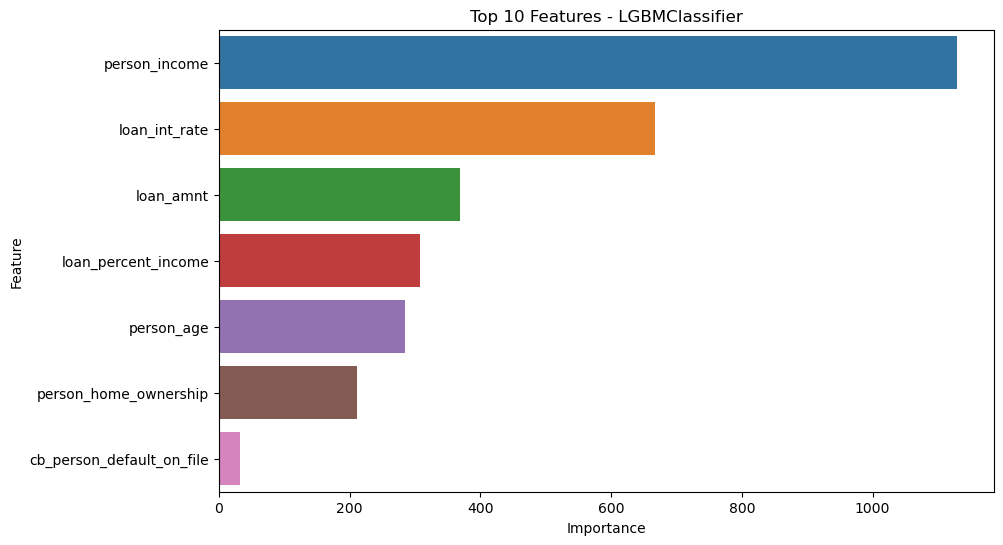

In [85]:
# Train models that support feature importances
models_with_feature_importances = [("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
                                   ("RandomForestClassifier", RandomForestClassifier(n_estimators=100, random_state=42)),
                                   ("XGBClassifier", XGBClassifier(random_state=42)),
                                   ("LGBMClassifier", LGBMClassifier(random_state=42))]

# Iterate over models
for model_name, model in models_with_feature_importances:
    
    # Train model
    model.fit(X_train, y_train)
    
    # Get importance of features
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        # If the model does not have feature_importances_, continue to the next model
        print(f"{model_name} does not support feature importances.")
        continue

    # Create DataFrame for easier viewing
    feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 
                                           'Importance': feature_importances})
    
    # Sort by importance
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df[:10])
    plt.title(f"Top 10 Features - {model_name}")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(False)
    plt.show()

Model 1: GaussianNB
Training Accuracy: 0.8130408959782793
Testing Accuracy: 0.8145257084676735


Confusion matrix 

 [[4363  222]
 [ 871  437]]

True Positives(TP) =  4363

True Negatives(TN) =  437

False Positives(FP) =  222

False Negatives(FN) =  871



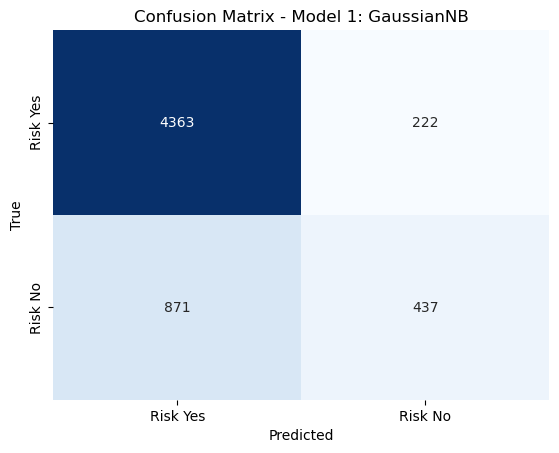

------------------
Model 2: DecisionTreeClassifier
Training Accuracy: 0.9997030375021212
Testing Accuracy: 0.8528762939080264


Confusion matrix 

 [[4126  459]
 [ 408  900]]

True Positives(TP) =  4126

True Negatives(TN) =  900

False Positives(FP) =  459

False Negatives(FN) =  408



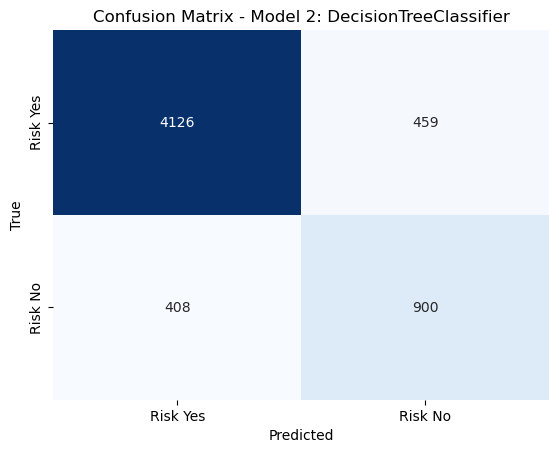

------------------
Model 3: RandomForestClassifier
Training Accuracy: 0.9997030375021212
Testing Accuracy: 0.8978449007296793


Confusion matrix 

 [[4425  160]
 [ 442  866]]

True Positives(TP) =  4425

True Negatives(TN) =  866

False Positives(FP) =  160

False Negatives(FN) =  442



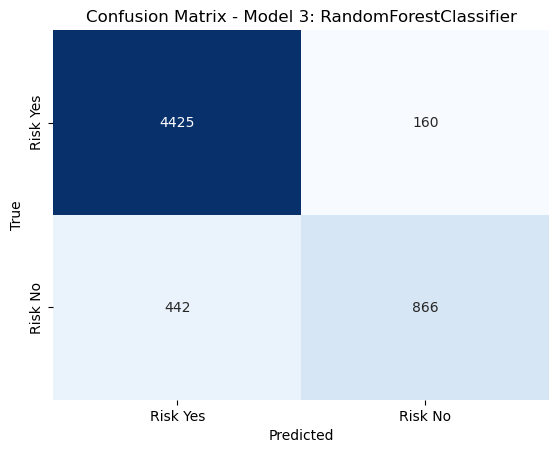

------------------
Model 4: LogisticRegression
Training Accuracy: 0.8042168674698795
Testing Accuracy: 0.8046835228236892


Confusion matrix 

 [[4519   66]
 [1085  223]]

True Positives(TP) =  4519

True Negatives(TN) =  223

False Positives(FP) =  66

False Negatives(FN) =  1085



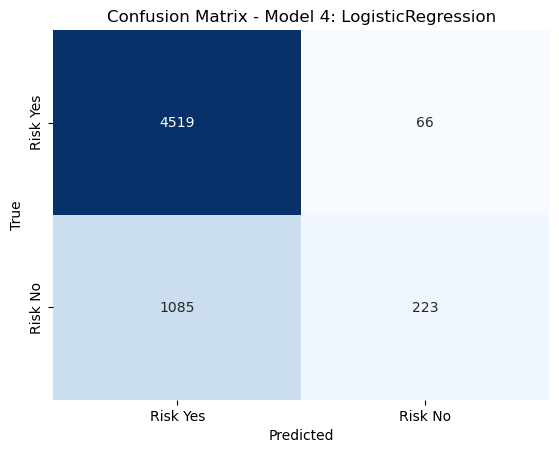

------------------
Model 5: AdaBoostClassifier
Training Accuracy: 0.8719667402002376
Testing Accuracy: 0.8695061937892414


Confusion matrix 

 [[4331  254]
 [ 515  793]]

True Positives(TP) =  4331

True Negatives(TN) =  793

False Positives(FP) =  254

False Negatives(FN) =  515



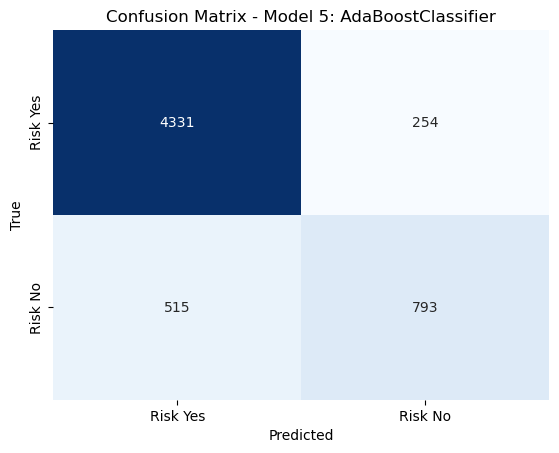

------------------
Model 6: XGBClassifier
Training Accuracy: 0.9358985236721534
Testing Accuracy: 0.9010690649923638


Confusion matrix 

 [[4440  145]
 [ 438  870]]

True Positives(TP) =  4440

True Negatives(TN) =  870

False Positives(FP) =  145

False Negatives(FN) =  438



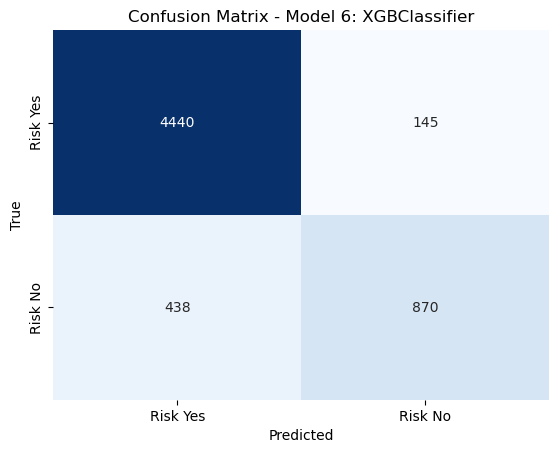

------------------
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 5156, number of negative: 18416
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.176432
[LightGBM] [Debug] init for col-wise cost 0.000001 seconds, init for row-wise cost 0.000295 seconds
[LightGBM] [Info] Auto-choosing 

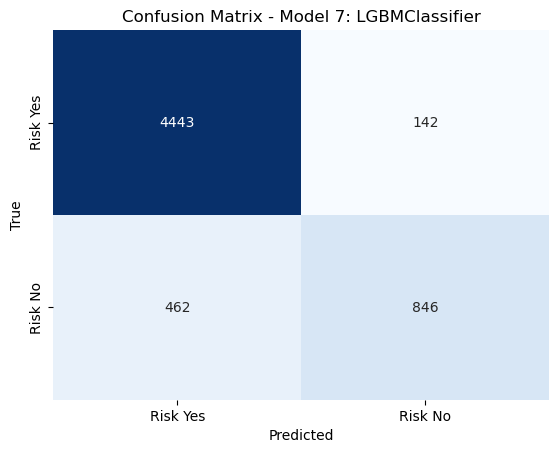

------------------
Model 8: KNeighborsClassifier
Training Accuracy: 0.8482521635839131
Testing Accuracy: 0.8415068725606651


Confusion matrix 

 [[4388  197]
 [ 737  571]]

True Positives(TP) =  4388

True Negatives(TN) =  571

False Positives(FP) =  197

False Negatives(FN) =  737



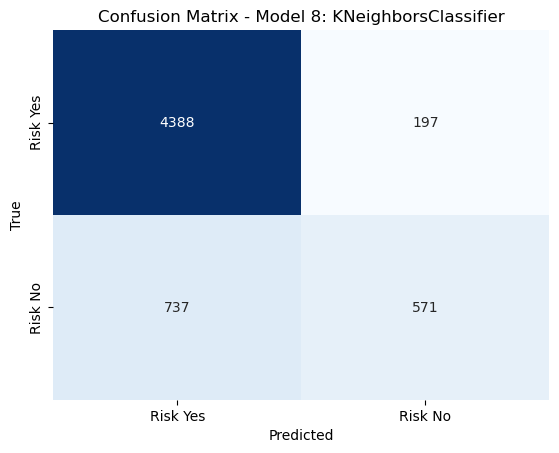

------------------


In [86]:
# plot matrix confusion
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluate each model
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    print(f"Model {i+1}: {type(model).__name__}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")
    print()

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    print()
    print('Confusion matrix \n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])
    print()
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=["Risk Yes", "Risk No"], 
                yticklabels=["Risk Yes", "Risk No"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Model {i+1}: {type(model).__name__}")
    plt.show()
    print("------------------")

In [87]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Models to be evaluated
models = [
          GaussianNB(),
          DecisionTreeClassifier(random_state=42),
          KNeighborsClassifier(),
          RandomForestClassifier(n_estimators=100, random_state=42),
          LogisticRegression(random_state=42),
          AdaBoostClassifier(random_state=42),
          XGBClassifier(random_state=42),
          LGBMClassifier()]

# Evaluate each model
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    print()
    
    print(f"Model {i+1}: {type(model).__name__}")
    print()
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Generate rating report
    report = classification_report(y_test, model.predict(X_test))
    print()
    print("Classification Report:")
    print()
    print(report)
    print()
    
    print("=======================================")


Model 1: GaussianNB

Training Accuracy: 0.8130408959782793
Testing Accuracy: 0.8145257084676735

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4585
           1       0.66      0.33      0.44      1308

    accuracy                           0.81      5893
   macro avg       0.75      0.64      0.67      5893
weighted avg       0.80      0.81      0.79      5893



Model 2: DecisionTreeClassifier

Training Accuracy: 0.9997030375021212
Testing Accuracy: 0.8528762939080264

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4585
           1       0.66      0.69      0.67      1308

    accuracy                           0.85      5893
   macro avg       0.79      0.79      0.79      5893
weighted avg       0.86      0.85      0.85      5893



Model 3: KNeighborsClassifier

Training Accuracy: 0.8776090276599355
Testing Accuracy: 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11

Model 8: LGBMClassifier

Training Accuracy: 0.9188019684371288
Testing Accuracy: 0.9012387578482945

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0

In [106]:
X_test.columns

Index(['person_age', 'person_income', 'person_home_ownership', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file'],
      dtype='object')

In [103]:
input_data = np.array([30, 15600, 0, 6250, 5.79, 0.40, 0]).reshape(1, -1)
prediction = model.predict(input_data)

print(prediction)

[1]


In [104]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'demographic.pkl')

['demographic.pkl']